In [55]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [56]:
retail = pd.read_parquet('retail_data_eda.parquet')

### Cluster items based on Description

In [3]:
unique_items = retail['Description'].unique()
unique_items

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'mixed up',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [4]:
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(unique_items)

In [13]:
# Determine the optimal number of clusters using the silhouette score
best_score = -1
best_n_clusters = 2
scores = []

for n_clusters in tqdm(range(2, 10, 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    scores.append([n_clusters, kmeans.inertia_, silhouette_avg])
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

  0%|          | 0/8 [00:00<?, ?it/s]

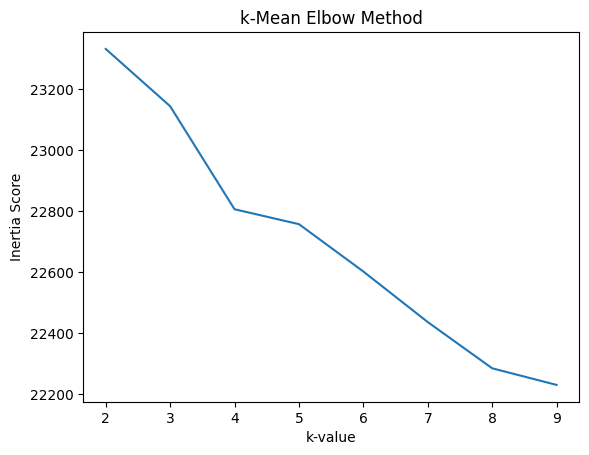

In [15]:
# Plot the intertia scores for the elbow method
plt.plot([x[0] for x in scores], [x[1] for x in scores])
plt.xlabel('k-value')
plt.ylabel('Inertia Score')
plt.title('k-Mean Elbow Method')
plt.xticks(range(2,10))
plt.show()

In [16]:
# Best cluster for silhouette score 
best_n_clusters

4

In [20]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=0, n_init='auto')

In [21]:
items_labels = pd.DataFrame({'Description' : unique_items, 'ItemClusters':kmeans.fit_predict(matrix)})

In [22]:
items_labels['ItemClusters'].value_counts()

1    4420
0     460
2     456
3     362
Name: ItemClusters, dtype: int64

In [57]:
# Merge ItemClusters back to Retail
retail = retail.merge(items_labels, on='Description')

In [143]:
customer_segments = retail.groupby(by=['Customer ID']).agg(NumberOfTransactions = ('Invoice', 'nunique'),
                                                           PurchasedQuantity = ('Quantity', 'sum'),
                                                           TotalSpent = ('InvoiceTotal', 'sum'),
                                                           CancelledTransactionCounts = ('IsCancellation', 'sum'),
                                                           HolidayQuantity = ('HolidayQuantity', 'sum'),
                                                           #ItemClusters = ('ItemClusters', lambda x: x.value_counts().to_dict())
                                                            )

In [144]:
# Change to bools
customer_segments['HolidayPurchase'] = (customer_segments['HolidayQuantity'] != 0).astype(int)
customer_segments['CancelledTransactions'] = (customer_segments['CancelledTransactionCounts'] > 0).astype(int)

In [145]:
# Remove the 'NaN' customers
customer_segments = customer_segments.loc[customer_segments.index != 'nan', :]

In [147]:
customer_segments

NumberOfTransactions  PurchasedQuantity  TotalSpent  \
Customer ID                                                        
12346                           7                  7     -263.68   
12347                           8               3286     5633.32   
12348                           5               2714     2019.40   
12349                           5               1619     4404.54   
12350                           1                197      334.40   
...                           ...                ...         ...   
18283                          22               1733     2736.65   
18284                           2                493      436.68   
18285                           1                145      427.00   
18286                           3                592     1188.43   
18287                           8               3011     4177.89   

             CancelledTransactionCounts  HolidayQuantity  HolidayPurchase  \
Customer ID                                                                 
12346                                13             -1.0                1   
12347                                 0           2015.0                1   
12348                                 0           1254.0                1   
12349                                 5           1145.0                1   
12350                                 0              0.0                0   
...                                 ...              ...              ...   
18283                                 0            773.0                1   
18284                                 1            493.0                1   
18285                                 0              0.0                0   
18286                                 3            114.0                1   
18287                                 1           1283.0                1   

             CancelledTransactions  
Customer ID                         
12346                            1  
12347                            0  
12348                            0  
12349                            1  
12350                            0  
...                            ...  
18283                            0  
18284                            1  
18285                            0  
18286                            1  
18287                            1  

[5940 rows x 7 columns]

In [148]:
# # Add back the item clusters to the customers
# customer_segments = customer_segments.merge(customer_segments['ItemClusters'].apply(pd.Series),
#                                            left_index=True, 
#                                            right_index=True)\
#                                      .drop(columns='ItemClusters')

### Look for Clusters on Customer Dataset

In [149]:
scaler = StandardScaler()
scaled_customers_data = scaler.fit_transform(customer_segments.fillna(0).values)

In [150]:
# Determine the optimal number of clusters using the silhouette score
best_score = -1
best_n_clusters = 2
scores = []

for n_clusters in tqdm(range(2, 10, 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init='auto')
    cluster_labels = kmeans.fit_predict(scaled_customers_data) # Need to fill NAs with 0
    silhouette_avg = silhouette_score(scaled_customers_data, cluster_labels)
    scores.append([n_clusters, kmeans.inertia_, silhouette_avg])
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

  0%|          | 0/8 [00:00<?, ?it/s]

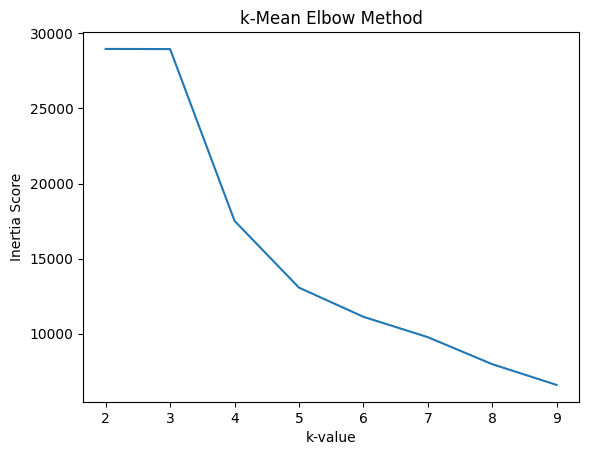

In [151]:
# Plot the intertia scores for the elbow method
plt.plot([x[0] for x in scores], [x[1] for x in scores])
plt.xlabel('k-value')
plt.ylabel('Inertia Score')
plt.title('k-Mean Elbow Method')
plt.xticks(range(2,10))
plt.show()

In [152]:
kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++', n_init='auto')

In [153]:
customer_segments['Segment'] = kmeans.fit_predict(scaled_customers_data)

In [154]:
customer_segments['Segment'].value_counts()

2    2138
1    2044
0    1749
3       9
Name: Segment, dtype: int64

In [155]:
# Look at the description of the customer segments as a whole
customer_segments.describe().round(2)

NumberOfTransactions  PurchasedQuantity  TotalSpent  \
count               5940.00            5940.00     5940.00   
mean                   7.55            1722.91     2802.71   
std                   15.97            8564.64    13976.19   
min                    1.00           -1085.00   -25111.09   
25%                    2.00             180.00      325.62   
50%                    4.00             474.00      844.40   
75%                    8.00            1341.00     2182.72   
max                  510.00          365220.00   598215.22   

       CancelledTransactionCounts  HolidayQuantity  HolidayPurchase  \
count                     5940.00          5940.00          5940.00   
mean                         3.15           589.62             0.70   
std                         11.42          2571.71             0.46   
min                          0.00         -1340.00             0.00   
25%                          0.00             0.00             0.00   
50%                          0.00           159.00             1.00   
75%                          2.00           496.00             1.00   
max                        366.00        106217.00             1.00   

       CancelledTransactions  Segment  
count                5940.00  5940.00  
mean                    0.43     1.07  
std                     0.50     0.81  
min                     0.00     0.00  
25%                     0.00     0.00  
50%                     0.00     1.00  
75%                     1.00     2.00  
max                     1.00     3.00

In [245]:
def get_summary_statistics(df, col_name):
    """Function wrapper for easier calculation and plotting"""
    df = df.groupby('Segment')[col_name].apply(lambda x: list(np.percentile(x, range(10,100,10))))
    df = df.to_frame()[col_name].apply(pd.Series)
    df.columns = (f"{x}%" for x in range(10, 100, 10))
    
    print(col_name)
    fig, ax = plt.subplots(figsize=(10, 5))
    df.T.plot(ax=ax)
    plt.xlabel('Percentiles')
    plt.ylabel(col_name)
    plt.title(f'Percentile Breakdowns for {col_name}')
    #plt.yscale('log')
    plt.show()

NumberOfTransactions


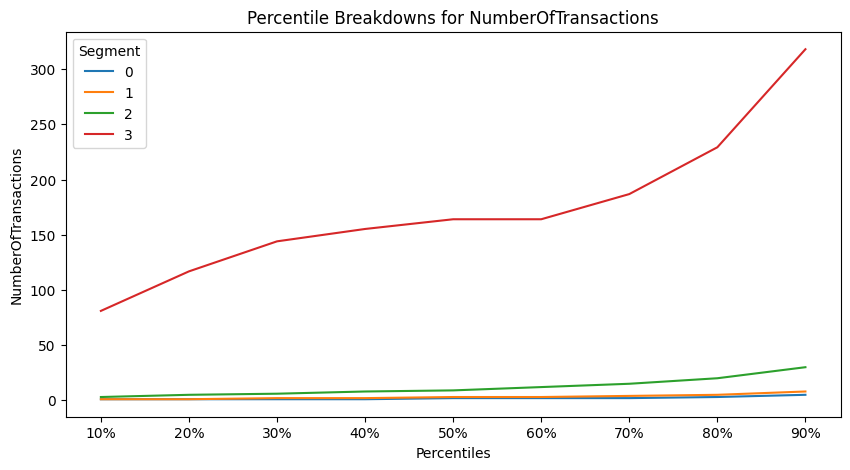

PurchasedQuantity


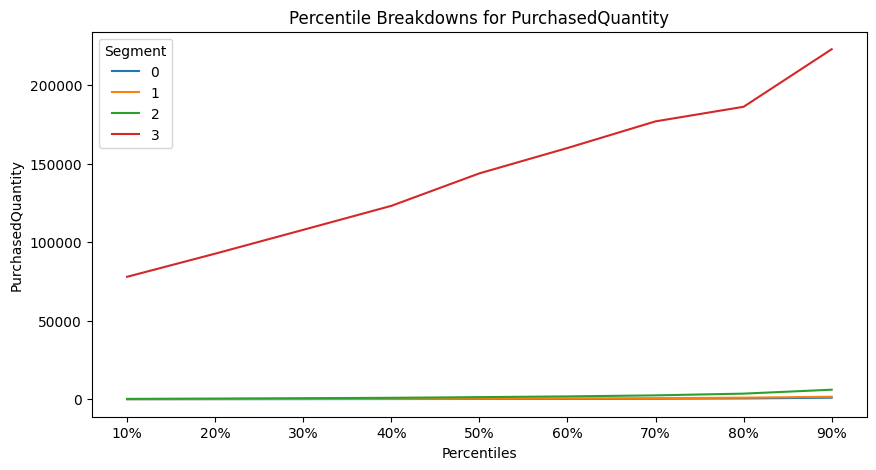

HolidayQuantity


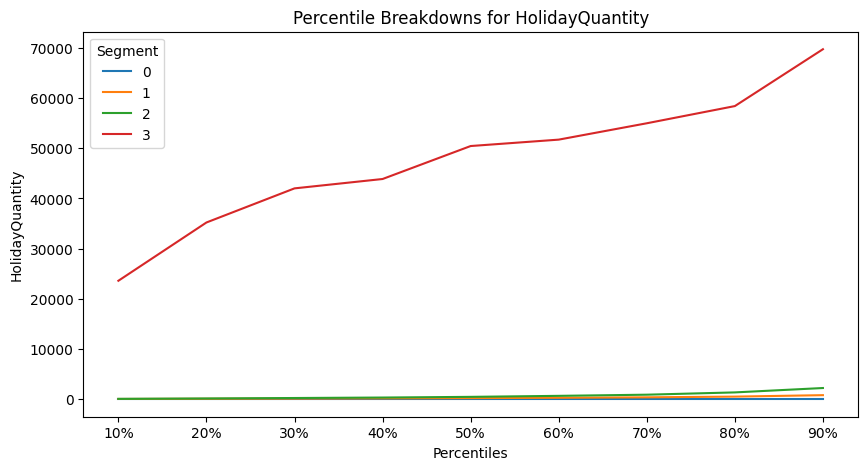

TotalSpent


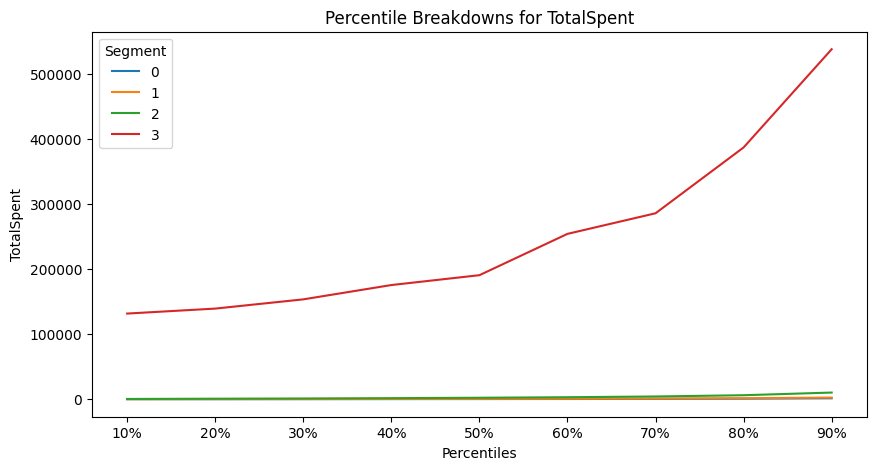

In [247]:
for col in ['NumberOfTransactions', 'PurchasedQuantity', 'HolidayQuantity', 'TotalSpent']:
    get_summary_statistics(customer_segments, col)

NumberOfTransactions


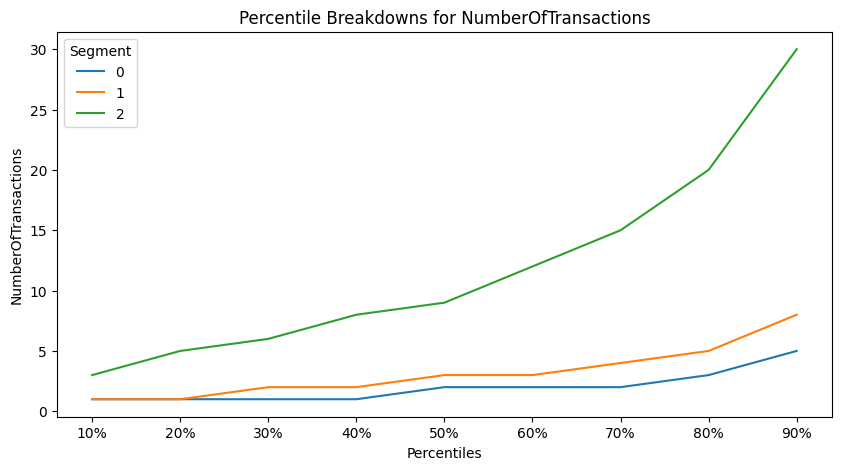

PurchasedQuantity


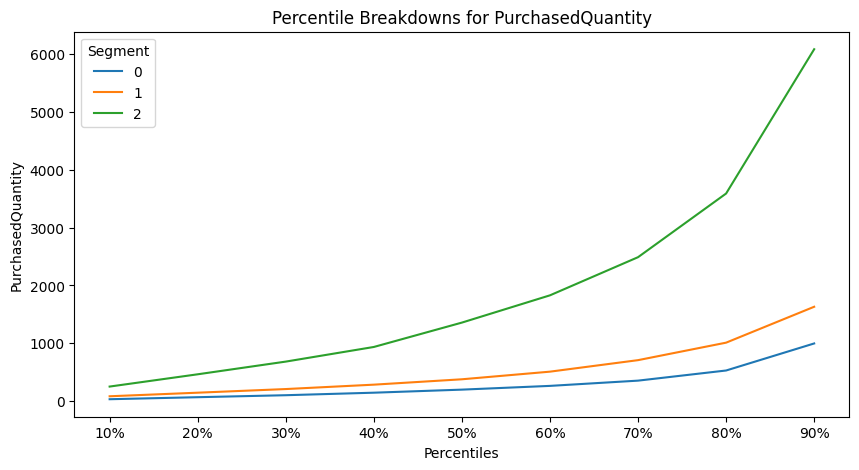

HolidayQuantity


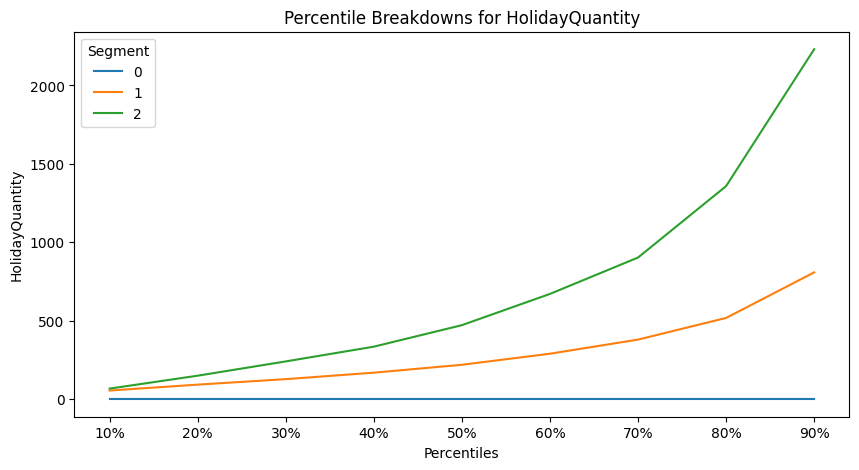

TotalSpent


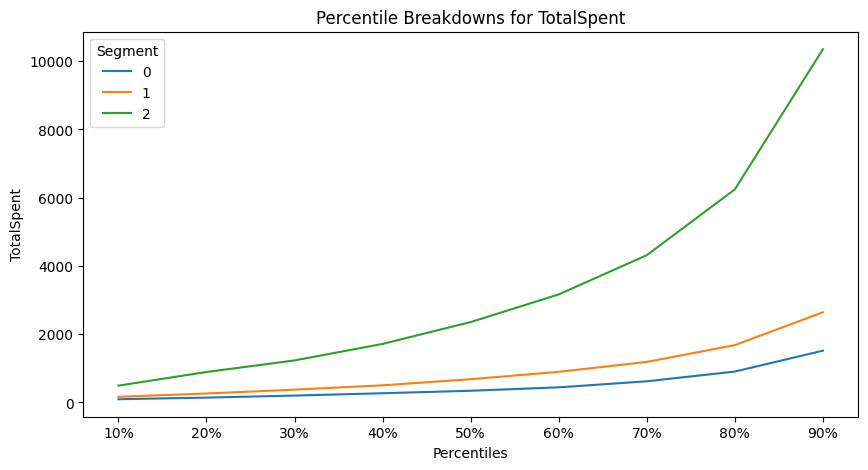

In [249]:
for col in ['NumberOfTransactions', 'PurchasedQuantity', 'HolidayQuantity', 'TotalSpent']:
    get_summary_statistics(customer_segments[customer_segments['Segment'] != 3], col)

In [263]:
retail

Invoice StockCode                          Description  Quantity  \
0         489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        C489518     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        -1   
2        C489528     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        -1   
3        C489551     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        -1   
4         489559     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
...          ...       ...                                  ...       ...   
1067349   581439    85123A   CREAM HANGING HEART T-LIGHT HOLDER         1   
1067350   581492    85123A   CREAM HANGING HEART T-LIGHT HOLDER         3   
1067351   581538    85123A   CREAM HANGING HEART T-LIGHT HOLDER         1   
1067352   581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
1067353  C581484     23843          PAPER CRAFT , LITTLE BIRDIE    -80995   

                InvoiceDate  Price Customer ID         Country  \
0       2009-12-01 07:45:00   6.95       13085  United Kingdom   
1       2009-12-01 11:35:00   7.95       15461  United Kingdom   
2       2009-12-01 11:50:00   7.95       16714  United Kingdom   
3       2009-12-01 12:35:00   6.95       17641  United Kingdom   
4       2009-12-01 12:55:00   6.95       17056  United Kingdom   
...                     ...    ...         ...             ...   
1067349 2011-12-08 16:30:00   5.79         nan  United Kingdom   
1067350 2011-12-09 10:03:00   5.79         nan  United Kingdom   
1067351 2011-12-09 11:34:00   2.95       14446  United Kingdom   
1067352 2011-12-09 09:15:00   2.08       16446  United Kingdom   
1067353 2011-12-09 09:27:00   2.08       16446  United Kingdom   

         IsCancellation InvoiceDateOnly InvoiceTimeOnly  HolidayQuantity  \
0                 False      2009-12-01           07:45             12.0   
1                  True      2009-12-01           11:35             -1.0   
2                  True      2009-12-01           11:50             -1.0   
3                  True      2009-12-01           12:35             -1.0   
4                 False      2009-12-01           12:55             12.0   
...                 ...             ...             ...              ...   
1067349           False      2011-12-08           16:30              1.0   
1067350           False      2011-12-09           10:03              3.0   
1067351           False      2011-12-09           11:34              1.0   
1067352           False      2011-12-09           09:15          80995.0   
1067353            True      2011-12-09           09:27         -80995.0   

        HolidayOrder  CancelledQuantity  InvoiceTotal  ItemClusters  
0             489434                NaN         83.40             2  
1            C489518               -1.0         -7.95             2  
2            C489528               -1.0         -7.95             2  
3            C489551               -1.0         -6.95             2  
4             489559                NaN         83.40             2  
...              ...                ...           ...           ...  
1067349       581439                NaN          5.79             1  
1067350       581492                NaN         17.37             1  
1067351       581538                NaN          2.95             1  
1067352       581483                NaN     168469.60             1  
1067353      C581484           -80995.0    -168469.60             1  

[1067354 rows x 16 columns]

In [265]:
retail.merge(customer_segments.reset_index()[['Customer ID', 'Segment']])\
        [['Segment', 'InvoiceDateOnly', 'Invoice', 'Quantity']].to_parquet('retail_data_forecast.parquet')